In [1]:
# todo
# understand the loss that we get from the validation
# see if we understand which ones it does best at following and assessing

from importlib import reload
import random
import torch
import os
import numpy as np
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import pickle

import trainer
reload(trainer)

import mcts.networks
reload(mcts.networks)

import augmentor
reload(augmentor)

from trainer import PatternTrainer
from mcts.networks import PatternsNet
from plotting import PatternPlotter
from augmentor import StateAugmentor

my_device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


In [ ]:
### load a network and assess the accuracy

# save location for the state dictionary:
npaths = ["2025_07_02_17_49",
          "2025_07_02_19_04",
          "2025_07_03_12_18",
          "2025_07_03_13_28",
          "2025_07_03_15_17",
          "2025_07_03_16_37",
          "2025_07_03_17_44",
          "2025_07_03_21_08",
          "2025_07_03_22_57",
          "2025_07_04_13_54",
          "2025_07_04_15_11",
         ]

# todo need some way to get the meta characteristics in a file so that can always be loaded if the 
# architecture changes:

# path locations:
nlocs = [os.path.join(Path.cwd(), 'saved_networks', network_path + '.pt') for network_path in npaths]

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, nlocs):
    _net.load_state_dict(torch.load(_nloc, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

# string and data path for the validation games:
valid_path = "VALID_2025_07_02_07_57.pkl"
dloc = os.path.join(Path.cwd(), 'saved_games', valid_path)

# assess the losses for the network in question:
for _t in ts:
    _win_acc, _loss_acc, _draw_acc = _t.validate_value(data_location=dloc,
                                                       num_check=2000,
                                                       is_augment=True,
                                                       is_plot=True)
    
    print(_win_acc, _loss_acc, _draw_acc)


In [2]:
### load a network and assess the accuracy

# save location for the state dictionary:
npaths = [
          "2025_07_04_13_54",
         ]

# todo need some way to get the meta characteristics in a file so that can always be loaded if the 
# architecture changes:

# path locations:
nlocs = [os.path.join(Path.cwd(), 'saved_networks', network_path + '.pt') for network_path in npaths]

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, nlocs):
    _net.load_state_dict(torch.load(_nloc, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

# string and data path for the validation games:
valid_path = "VALID_2025_07_02_07_57.pkl"
dloc = os.path.join(Path.cwd(), 'saved_games', valid_path)


In [3]:
my_trainer = ts[0]
data_location = dloc
num_check = 2000
is_augment = True
is_plot = False

validation_games = my_trainer.load_data(data_location)

# set network to eval mode:
my_trainer.network.eval()

# split the data set:
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]


In [ ]:

win_predictions, win_length = my_trainer.get_MSE_accuracy(wins, num_check, is_augment=is_augment)
loss_predictions, loss_length = my_trainer.get_MSE_accuracy(losses, num_check, is_augment=is_augment)
draw_predictions, draw_length = my_trainer.get_MSE_accuracy(draws, num_check, is_augment=is_augment)

In [ ]:
[x for x in loss_predictions[0]]

In [7]:
def get_preds(games, num_to_take):
    # get the states from the games:
    _states, _vcs, _, _flipped_num, _ = zip(*games[:num_to_take])
    
    # stack the tensors:
    state_tensor = torch.stack(_states)
    vc_tensor = torch.tensor(np.stack(_vcs))
    
    # augment the states:
    states, _visit_counts = my_trainer.augment_sample(state_tensor, vc_tensor, is_augment=True)
    
    # get the predicted results and the policy vectors for the states considered:
    with torch.no_grad():
        # do not collect the prior policy here:
        predictions, _ = my_trainer.network(states.to(my_trainer.device).float())

    return predictions

draw_preds = get_preds(draws, 20)
win_preds = get_preds(wins, 20)
loss_preds = get_preds(losses, 20)

In [8]:
draw_preds, win_preds, loss_preds

(tensor([[ 9.8731e-01],
         [-1.5469e-02],
         [-1.4153e-01],
         [-9.6480e-01],
         [ 9.9999e-01],
         [ 6.4191e-01],
         [ 9.9997e-01],
         [-9.8854e-01],
         [-9.9463e-01],
         [ 9.7941e-01],
         [ 9.7172e-01],
         [ 9.8304e-01],
         [ 1.6718e-03],
         [ 9.2713e-01],
         [-4.3224e-04],
         [ 1.3726e-03],
         [-8.4370e-02],
         [-9.7138e-01],
         [ 2.9843e-01],
         [-9.8856e-01]], device='cuda:0'),
 tensor([[1.0000],
         [1.0000],
         [1.0000],
         [0.9999],
         [0.9999],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [0.9999],
         [0.9944]], device='cuda:0'),
 tensor([[-0.9973],
         [-0.9994],
         [ 0.0111],
         [-0.9366],
         [-0.9997],
  

In [23]:
check_visit_counts

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

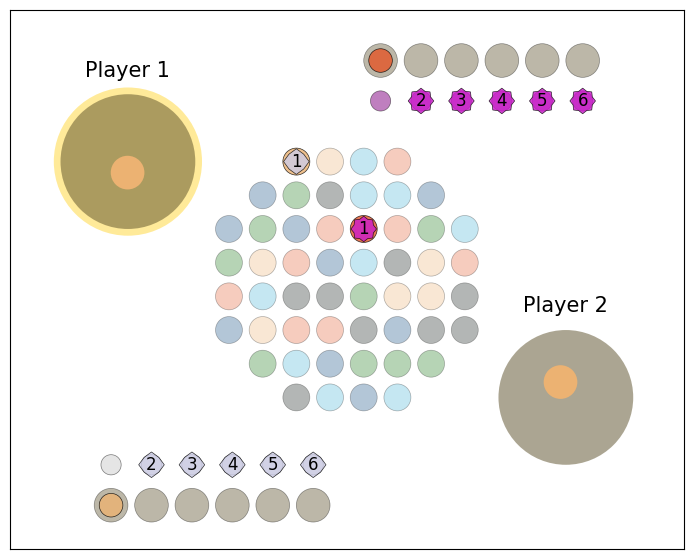

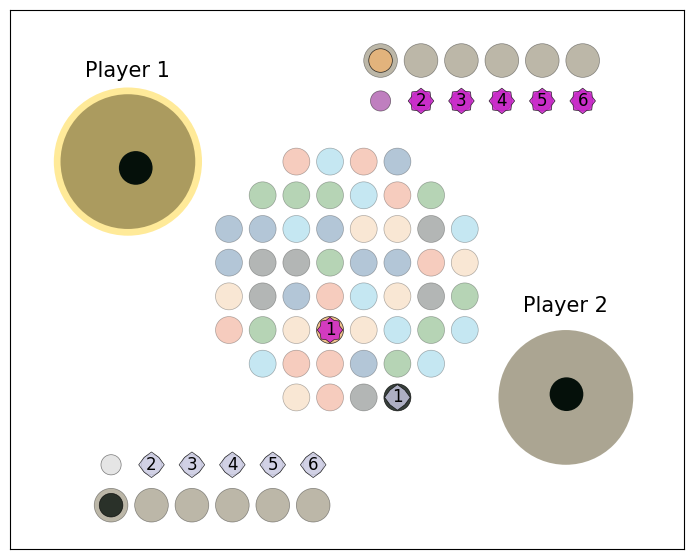

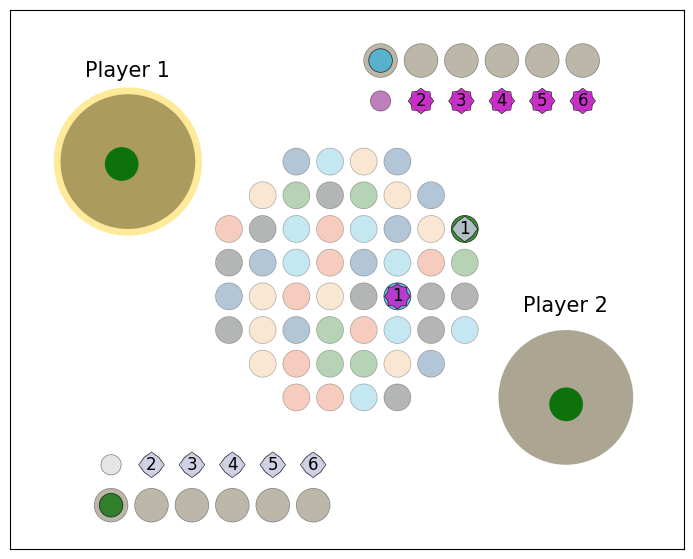

(1, 1) (1, 1) (1, 1)
1 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0067, 0.0067, 0.3333,
        0.1667], dtype=torch.float64)


In [22]:
# create the game, see if you understand how it performs

_check = copy.deepcopy(wins[0])

check_tensor = _check[0]
check_visit_counts = _check[1]
check_distance_from_terminal = _check[2]
check_flipped = _check[3]
check_nod_result = _check[4]

# use augmentor to create a non-augmented game:
paug = StateAugmentor(check_tensor)
recreated_game = paug.create_game_from_state()

# fully augment, permuting the colors and rotating/ flipping:
paug.full_augment()
aug_game_1 = paug.create_game_from_state()

# and again:
paug.full_augment()    
aug_game_2 = paug.create_game_from_state()

pplotter_1 = PatternPlotter(recreated_game)
pplotter_2 = PatternPlotter(aug_game_1)
pplotter_3 = PatternPlotter(aug_game_2)

pplotter_1.plot()
pplotter_2.plot()
pplotter_3.plot()

print(aug_game_1.calculate_score(), aug_game_2.calculate_score(), recreated_game.calculate_score())
print(check_nod_result, check_tensor[-10:, 0, 0])


In [17]:
check_tensor[:18, 5, 4], 0.0933 * 150


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        dtype=torch.float64),
 13.995)

In [13]:
active_order = aug_game_1.active_color_order
passive_order = aug_game_1.passive_color_order
active_color_groups = aug_game_1.active_color_groups
passive_color_groups = aug_game_1.passive_color_groups

active_score = 0
passive_score = 0

for _col, (aorder, porder) in enumerate(zip(active_order, passive_order)):
    active_score += len(active_color_groups[_col]) * aorder
    passive_score += len(passive_color_groups[_col]) * porder

print(active_score, passive_score)

14 17


In [27]:
losing_action_arguments = [0, 1, 4]

possible_actions = [23, 15, 8, 4, 55, 12]
visit_counts = np.array([10, 20, 30, 5, 3, 1])
okay_arguments = list(set(range(len(possible_actions))) - set(losing_action_arguments))
okay_arguments

[2, 3, 5]

In [29]:
filtered_visit_counts = visit_counts[okay_arguments]
filtered_visit_counts

array([30,  5,  1])

In [30]:
temperature= 1.0
selection_scores = filtered_visit_counts ** (1.0 / temperature)
selection_scores /= selection_scores.sum()
np.random.choice(okay_arguments, p=selection_scores).item()

5

In [31]:
_argmax = np.argmax(filtered_visit_counts)
okay_arguments[_argmax]

2